# Importation des Librairies et Traitement des Données

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
#from functions  import *

## Traitement des Données

In [2]:
data = pd.read_csv('billets.csv', sep=";")
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [3]:
data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [4]:
data.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [5]:
data.duplicated().sum()

0

In [6]:
data.drop(columns= 'is_genuine').duplicated().sum()

0

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


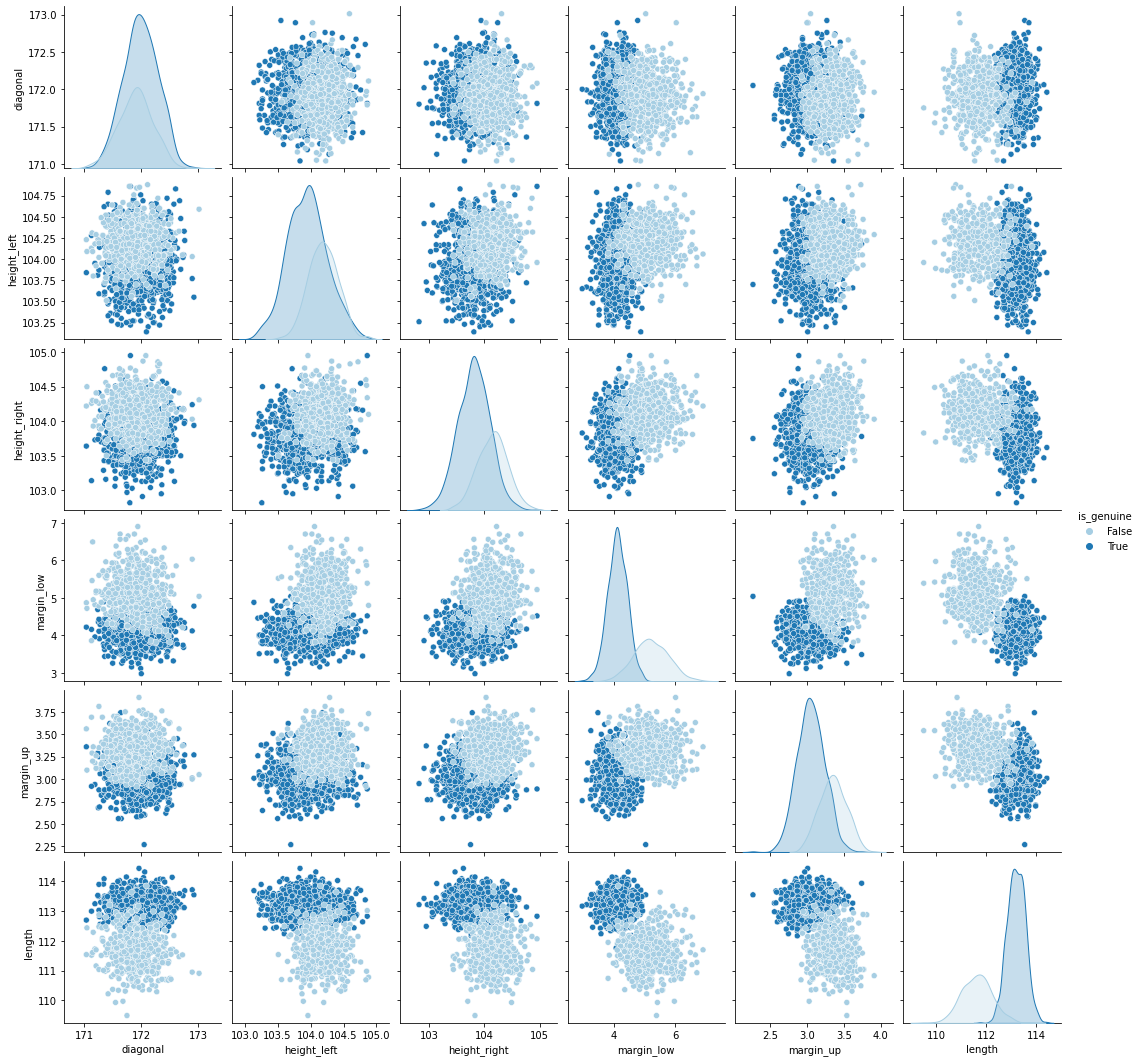

In [8]:
#faire un graphique croisant toutes les variables 
#voir s'il y'a des points atypique et les variables corrélées
# Pair plot
sns.pairplot(data, hue="is_genuine", palette="Paired")

"lengh" et "margin_low" sont les dimenssions qui distinguent le plus les billets trues des falses d'après les nuages de point et les courbes.

Valeurs de margin low selon true/false, on observe un décalage dans la dispersion des billets selons qu'ils soient true (3.5/5) et false (4/7) Les vrais billets ont des valeurs moins dispersés pour cette dimenssion, que les faux.

## Imputation des NAN par Regression Lineaire Multiple


### Création du modèle

In [9]:
data_sans_nan = data.dropna()


In [10]:
validation = data[data['margin_low'].isnull()]


<AxesSubplot:>

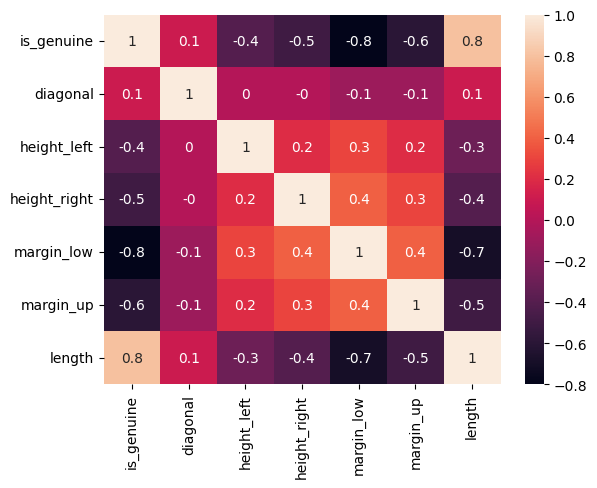

In [11]:
#etude de la correlation
matrice_corr = data.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)

##### Définir les variables explicatives et expliquées (X,y)

In [12]:
X=data_sans_nan.drop(["margin_low", "is_genuine"],axis=1)

y=data_sans_nan["margin_low"]
 

#### Création des bases test et d'apprentissage


On utilise pour le modèle les variables choisies ci-dessus ensuite on divise notre jeu de données en 2 parties (80%, pour l’apprentissage et les 20% restant pour le test.

In [13]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1170, 5)
(293, 5)
(1170,)
(293,)


###### On fait une concaténation X_train et Y_train

In [14]:
data_train = pd.concat([Y_train, X_train], axis = 1)
data_train

,margin_low,diagonal,height_left,height_right,margin_up,length
448,3.89,172.01,103.93,103.69,3.34,113.16
821,3.81,172.29,104.04,103.94,3.00,113.60
1396,4.75,171.91,104.53,104.23,3.34,112.28
1308,5.62,172.36,104.02,104.32,3.40,112.13
1004,5.60,172.55,104.25,104.23,3.13,111.72
...,...,...,...,...,...,...
1461,5.15,171.92,104.66,104.31,3.33,112.75
1173,4.82,172.12,104.38,104.31,3.18,111.82
1027,6.70,171.63,104.02,104.66,3.28,111.28
210,4.27,172.12,103.76,103.66,2.95,113.40


##### Adapté au modèle complet à nos données data_train

In [15]:
reg = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length',  data=data_train).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     217.3
Date:                Sat, 17 Sep 2022   Prob (F-statistic):          8.37e-164
Time:                        01:14:44   Log-Likelihood:                -779.26
No. Observations:                1170   AIC:                             1571.
Df Residuals:                    1164   BIC:                             1601.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       17.8019     10.579      1.683   

##### On enleve la variable non significative  intercept dans notre modele car p-value >5%

In [16]:
reg = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length -1',  data=data_train).fit()
print(reg.summary())

                                 OLS Regression Results                                
Dep. Variable:             margin_low   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          2.124e+04
Date:                Sat, 17 Sep 2022   Prob (F-statistic):                        0.00
Time:                        01:14:44   Log-Likelihood:                         -780.68
No. Observations:                1170   AIC:                                      1571.
Df Residuals:                    1165   BIC:                                      1597.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

##### On va maintenant retirer la variable non significative diagonal car elle a une p-value de 0.298 > 5%

In [17]:
reg = smf.ols('margin_low~height_left+height_right+margin_up+length -1',  data=data_train).fit()
print(reg.summary())

                                 OLS Regression Results                                
Dep. Variable:             margin_low   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          2.655e+04
Date:                Sat, 17 Sep 2022   Prob (F-statistic):                        0.00
Time:                        01:14:44   Log-Likelihood:                         -781.23
No. Observations:                1170   AIC:                                      1570.
Df Residuals:                    1166   BIC:                                      1591.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

#### Validation de notre modele

##### Calculez les résidus studentisés 

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, 
sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

Nous allons ici réaliser les tests à un niveau $\alpha=5$% 
Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [18]:
alpha = 0.05
n = data_train.shape[0]
p = 7

In [19]:
data_train['obs'] = np.arange(1, n+1)

In [20]:
data_train['rstudent'] = reg.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
seuil_rstudent


1.962007618038093

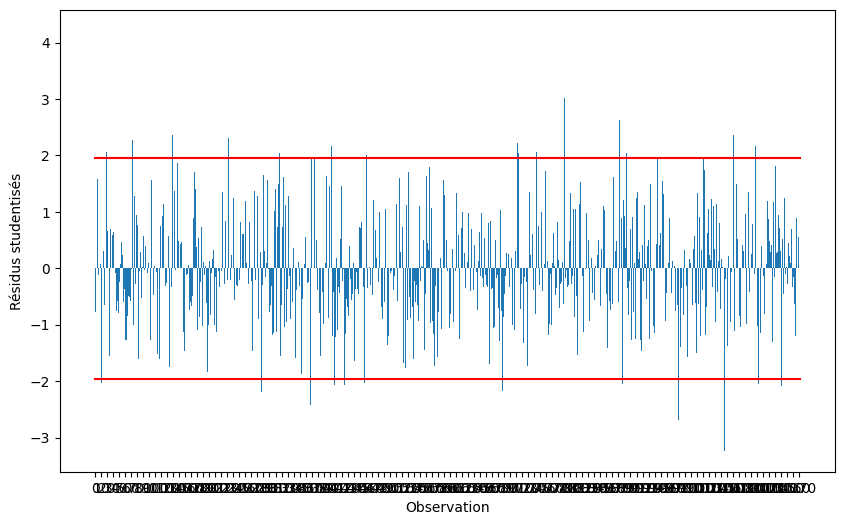

In [21]:
plt.figure(figsize=(10,6))
plt.bar(data_train['obs'], data_train['rstudent'])
plt.xticks(np.arange(0, n+1, step=10))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n+1], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n+1], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

En théorie, 95% des résidus se trouvent dans l’intervalle [-2,2]. C’est le cas ici puisque seulement environ 25 individus sur 1500 sont en dehors de cet intervalle. Les individus à l’extérieur de l’intervalle sont des individus extrêmes.

##### Normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [22]:
shapiro(reg.resid)

ShapiroResult(statistic=0.986751914024353, pvalue=8.156427533378974e-09)

Ici, l'hypothèse de normalité n'est pas remise en cause car (p-value = 8.15 > 0.05).

##### Testez l’homoscédasticité 

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [23]:
variables = reg.model.exog
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 5.637690712438865e-77


La p-valeur ici est  inférieure à $5$%, on accepte l'hypothese selon laquelle les  variances sont constantes (l'hypothèse d’homoscédasticité).

##### Calcul du  modéle final sur la base data_sans_nan(test +train)

In [24]:
reg = smf.ols('margin_low~height_left+height_right+margin_up+length -1',  data=data_sans_nan).fit()
print(reg.summary())

                                 OLS Regression Results                                
Dep. Variable:             margin_low   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          3.205e+04
Date:                Sat, 17 Sep 2022   Prob (F-statistic):                        0.00
Time:                        01:14:47   Log-Likelihood:                         -1005.2
No. Observations:                1463   AIC:                                      2018.
Df Residuals:                    1459   BIC:                                      2040.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

### Remplacer les valeurs nulles

On reccupere les coefficients des variables 

In [25]:
reg.params

height_left     0.199373
height_right    0.275462
margin_up       0.260037
length         -0.405604
dtype: float64

In [26]:
a= reg.params[0]
b=reg.params[1]
c=reg.params[2]
d=reg.params[3]


Remplacer les nan dans margin_low

In [27]:
data['margin_low'] = data['margin_low'].fillna( data['diagonal'] + a * data['height_left'] + b * data['height_right'] + c * data['margin_up'] +d * data['length'] ) 

On verifie s'il y'a des valeurs nulles 

In [28]:
data.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

# Régression logistique

In [29]:
#metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
#model selection
from sklearn.model_selection import train_test_split



display

In [30]:
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


##### On remplace True par 1 et False par 0

In [31]:
data['is_genuine'] = data['is_genuine'].apply(lambda x: 1 if x == True else 0)
data['is_genuine'].unique()

array([1, 0], dtype=int64)

On compte le nombre et le pourcentage de vrai et de faux billet

In [32]:
data.iloc[:, 0].value_counts()

1    1000
0     500
Name: is_genuine, dtype: int64

In [33]:
data.iloc[:, 0].value_counts(normalize = True).round(2)

1    0.67
0    0.33
Name: is_genuine, dtype: float64

##### renommer "is_genuine" en "target"

In [34]:
data = data.rename(columns={'is_genuine': 'target'})

In [35]:
data.head()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [36]:
data.tail()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
1495,0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0,172.06,104.28,104.06,5.17,3.46,112.25
1499,0,171.47,104.15,103.82,4.63,3.37,112.07


##### Définir les variables explicatives et expliquées (X,y)

In [37]:
X = data.drop(columns = 'target')
y = data.target

In [38]:
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [39]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

#### Création des bases test et d'apprentissage


On utilise pour le modèle les variables choisies ci-dessus ensuite on divise notre jeu de données en 2 parties (80%, pour l’apprentissage et les 20% restant pour le test

In [40]:
 X_train, X_test, y_train, y_test = train_test_split(X,
                                                     y,
                                                   test_size = 0.2,
                                                   random_state= 42,
                                                    stratify=y)

In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1200, 6)
(300, 6)
(1200,)
(300,)


###### On fait une concaténation X_train et y_train

In [42]:
data_train = pd.concat([X_train, y_train], axis = 1)

### Modélisation

Effectuons donc une régression logistique de target en fonction de toutes les autres variables sur la base du data_train

In [43]:
reg_log = smf.glm('target~margin_low+height_left+height_right+margin_up+length',
                   data=data_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1194
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -78.101
Date:                Sat, 17 Sep 2022   Deviance:                       156.20
Time:                        01:14:47   Pearson chi2:                 1.52e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6811
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -104.1977    116.751     -0.892   

###### Retirez les variables non significatives

On va donc retirer la variable non significative intercept car elle a une p-value de 0.372

In [44]:
reg_log = smf.glm('target~margin_low+height_left+height_right+margin_up+length-1',
                   data=data_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1195
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -78.500
Date:                Sat, 17 Sep 2022   Deviance:                       157.00
Time:                        01:14:47   Pearson chi2:                 1.25e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6809
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
margin_low       0.0192      0.012      1.659   

On voit alors que c'est maintenant margin_low, avec une p-valeur de 0.097, qui est la moins significative. On l'enlève donc.

In [45]:
reg_log = smf.glm('target~height_left+height_right+margin_up+length-1',
                   data=data_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1196
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -80.459
Date:                Sat, 17 Sep 2022   Deviance:                       160.92
Time:                        01:14:47   Pearson chi2:                 1.25e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6798
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
height_left     -2.7193      0.684     -3.973   

##### On fait les prédictions sur la base X_test

In [46]:
y_pred = reg_log.predict(X_test)
y_pred 

803     0.997601
1306    0.000238
1263    0.000005
38      0.554605
257     0.993840
          ...   
1445    0.001594
795     0.994227
301     0.999768
1241    0.000022
879     0.999918
Length: 300, dtype: float64

##### Matrice de confusion

In [47]:
y_pred = reg_log.predict(X_test)
prediction = list(map(round, y_pred))
  
# comparing original and predicted values of y
print('Actual values', list(y_test))
print('Predictions :', prediction)

Actual values [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1]
Predictions : [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1

In [48]:
mat = confusion_matrix(y_test, prediction)
mat = pd.DataFrame(mat)
mat.columns = [f" predicted_{i}" for i in mat.columns]
mat.index = [f" actual_{i}" for i in mat.index]
mat


,predicted_0,predicted_1
actual_0,94,6
actual_1,2,198


##### Accuracy score du modele

In [49]:
print('Test accuracy = ', accuracy_score(y_test, prediction))

Test accuracy =  0.9733333333333334


##### Courbe de ROC et AUC


La courbe ROC (Receiver Operating Characteristic) représente la sensibilité en fonction de la spécificité pour différents seuils de décision. L'aire sous la courbe ROC, l'AUC (Area Under the ROC ), est une mesure de la qualité de la classification qui varie entre 0.5 dans le pire des cas et 1 dans le meilleur des cas.

In [50]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

In [51]:
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9944

La mesure AUC est ici égale à 0.9944


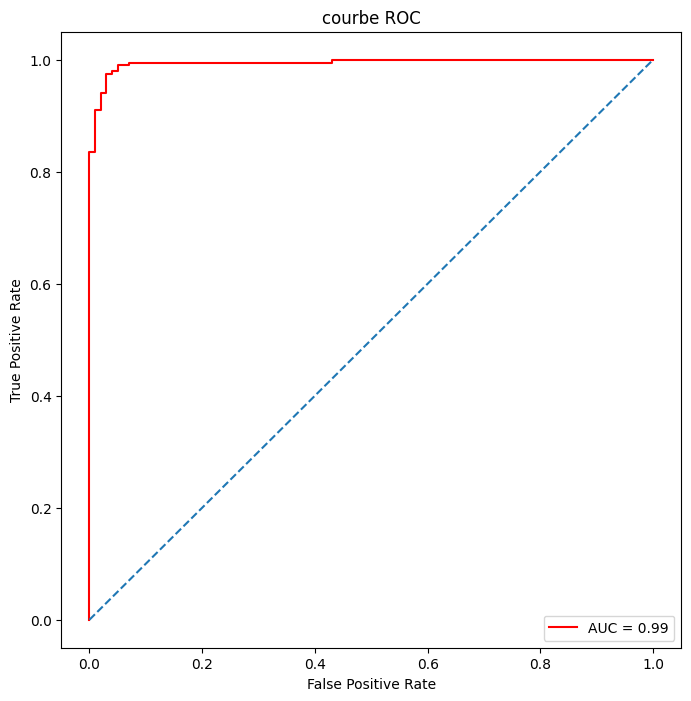

In [52]:
plt.figure(figsize = (8,8))
plt.title('courbe ROC')
plt.plot(false_positive_rate, true_positive_rate, color = "red", label= 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], linestyle= '--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Calcul du modele final sur la base des données train +test

In [53]:
reg_log2 = smf.glm('target~height_left+height_right+margin_up+length-1',
                   data=data, family=sm.families.Binomial()).fit()
print(reg_log2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1496
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -105.59
Date:                Sat, 17 Sep 2022   Deviance:                       211.18
Time:                        01:14:48   Pearson chi2:                 1.63e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6777
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
height_left     -2.5631      0.568     -4.511   

##### prediction

In [54]:
y_pred = reg_log2.predict(X)
y_pred

0       0.252962
1       0.999796
2       0.999151
3       0.999783
4       0.402094
          ...   
1495    0.000341
1496    0.000001
1497    0.007436
1498    0.013187
1499    0.030857
Length: 1500, dtype: float64

In [55]:
y_pred = reg_log2.predict(X)
prediction = list(map(round, y_pred))
  
# comparing original and predicted values of y
print('Actual values', list(y))
print('Predictions :', prediction)

Actual values [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

##### Matrice de confusion

In [56]:
mat = confusion_matrix(y, prediction)
mat = pd.DataFrame(mat)
mat.columns = [f" predicted_{i}" for i in mat.columns]
mat.index = [f" actual_{i}" for i in mat.index]
mat

,predicted_0,predicted_1
actual_0,475,25
actual_1,14,986


Le modele prédit 25 faux positifs et 14 faux négatifs sur l'ensemble des billets

In [57]:
print('Test accuracy = ', accuracy_score(y, prediction))

Test accuracy =  0.974


## verification du modèle sur les nouvelles observations 


1- Regression Logistique multiple (Reg_log2 base sur les dimenssions : height_left','height_right', 'margin_up', 'length)


2- Règle d'affectation : billet est vrai si probabilité prediction > 50%


3- Affichage des resultats (1 colonne avec la probabilité false et 1 colonne affectation de la nature du billet)

Voici notre fonction prediction à appliquer :

In [58]:
billet_prod = pd.read_csv('billets_production.csv', sep= ",")
billet_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [59]:
test_billet_prod = billet_prod[['height_left','height_right', 'margin_up', 'length']]
predict = reg_log2.predict(test_billet_prod)

prediction=pd.DataFrame({'id': billet_prod.index,
                         'prediction' : predict.values})
prediction['target_pred'] = prediction['prediction'].apply(lambda x: True if (x >= 0.5) else False)
prediction

,id,prediction,target_pred
0,0,0.004294,False
1,1,0.016591,False
2,2,0.000069,False
3,3,0.960772,True
4,4,0.999752,True


In [60]:
billet_prod = pd.concat([billet_prod,prediction], axis = 1)
billet_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id,id,prediction,target_pred
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0,0.004294,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,1,0.016591,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,2,0.000069,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,3,0.960772,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,4,0.999752,True


Le modéle prédit 

3 premiers faux

2 dernier vrai

# L'algorithme K-mean

In [61]:
X = data.drop(columns = 'target')
y = data.target

In [62]:
from sklearn import preprocessing

# Nombre de clusters souhaités
n_clust = 2

# import de l'échantillon
X = data.drop(columns = 'target')
y = data.target
# préparation des données pour le clustering
#X = data.values

# Les variables sont ici centrée réduites

X = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(init='k-means++', n_clusters=n_clust, random_state = 0)
km.fit(X)



# Récupération des clusters attribués à chaque individu
clusters = km.labels_


In [63]:
clusters

array([1, 0, 0, ..., 1, 1, 1])

In [64]:
data['cluster']= clusters

#data['cluster'].replace([1,0],[0,1],inplace = True)

In [65]:
data

,target,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,1,171.81,104.86,104.95,4.52,2.89,112.83,1
1,1,171.46,103.36,103.66,3.77,2.99,113.09,0
2,1,172.69,104.48,103.50,4.40,2.94,113.16,0
3,1,171.36,103.91,103.94,3.62,3.01,113.51,0
4,1,171.73,104.28,103.46,4.04,3.48,112.54,1
...,...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28,1
1496,0,172.19,104.63,104.44,5.27,3.37,110.97,1
1497,0,171.80,104.01,104.12,5.51,3.36,111.95,1
1498,0,172.06,104.28,104.06,5.17,3.46,112.25,1


matrice de confusion

In [66]:

y_actu = data['target']
y_pred = data['cluster']
mat = confusion_matrix(y_actu, y_pred)
mat = pd.DataFrame(mat)
mat.columns = [f" predicted_{i}" for i in mat.columns]
mat.index = [f" actual_{i}" for i in mat.index]
mat


,predicted_0,predicted_1
actual_0,21,479
actual_1,960,40


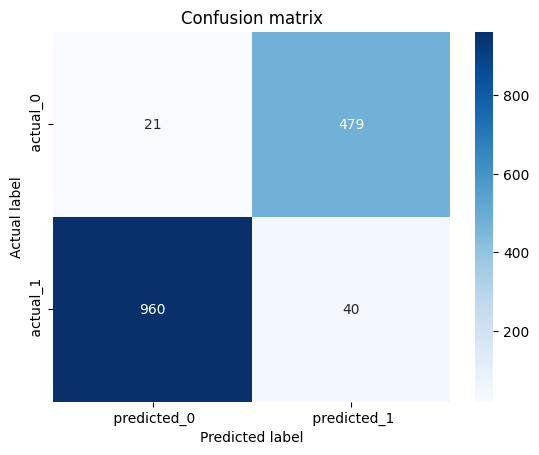

In [67]:
#Représentation graphique de la Matrice de confusion
sns.heatmap(pd.DataFrame(mat), annot=True, cmap="Blues",fmt='g')

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Comme attendu, notre classification n'est pas parfaite, globalement le cluster 0 semble plus correspondre aux Vrai billets pendant que le cluster 1 correspond plus au Faux.

## Vérification du modèle sur l'échantillon de test


1- Regression Logistique multiple (Reg_log2 base sur les dimenssions : height_left','height_right', 'margin_up', 'length)

2- Règle d'affectation : billet est vrai si prédiction = 0

3- Affichage des resultats (1 colonne avec la prediction, 1 colonne affectation de la nature du billet)

Voici notre fonction prediction à appliquer :

In [68]:
billet = pd.read_csv('billets_production.csv', sep= ",")
billet

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [69]:
# on définit X du nouveau jeu de donnée

X= billet.drop('id', axis=1)

km = KMeans(init='k-means++', n_clusters=2, random_state= 0)
km.fit(X)
predict =  km.predict(X)


prediction=pd.DataFrame({'id': billet_prod.index,
                         'prediction' : predict})
prediction['target_pred'] = prediction['prediction'].apply(lambda x: True if (x == 0) else False)
prediction

,id,prediction,target_pred
0,0,1,False
1,1,1,False
2,2,1,False
3,3,0,True
4,4,0,True


Le modele K-means fait les même prédictions que la régression logistique sur l'échantillon de test.

## Conclusion

Le K_means ne prend pas en compte la variable target, il ne fait que regrouper les valeurs proches entre elles. Notre échantillon de billets est donc sensible au clustering, mais cette methode n'est pas forcement pertinente pour predir si un billet est vrai/faux. Sur un autre échantillon de billet le resultat peut etre radicalement différent. La regression elle, predit la variable target en fonction des autres et "apprend", le modèle est aussi améliorable et plus pertinent comme modèle predictif.